#UNET

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

# Define a UNet class
class UNet:
    # Initialize the class with an input shape
    def __init__(self, input_shape=(28, 28, 1)):
        self.input_shape = input_shape  # Save the input shape as a class variable
        self.model = self.build_model()  # Call the build_model method to construct the U-Net

    # Define the encoder part of the U-Net
    def encoder(self, inputs):
        # First conv block: apply a 2D convolution with 32 filters, (3,3) kernel size, ReLU activation and same padding,
        # then apply 2D max pooling with (2,2) pool size
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        # Second conv block: similar to the first one but with 64 filters
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        # Return the outputs of the two conv blocks and the final pooled output
        return conv1, conv2, pool2

    # Define the decoder part of the U-Net
    def decoder(self, conv1, conv2, encoded):
        # First upscaling block: apply 2D upsampling with (2,2) size to the encoded input,
        # concatenate the result with the output of the second conv block from the encoder,
        # then apply a 2D convolution with 64 filters, (3,3) kernel size, ReLU activation and same padding
        up1 = UpSampling2D(size=(2, 2))(encoded)
        merge1 = Concatenate(axis=3)([conv2, up1])
        conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)

        # Second upscaling block: similar to the first one but concatenating with the output of the first conv block from the encoder and using 32 filters
        up2 = UpSampling2D(size=(2, 2))(conv3)
        merge2 = Concatenate(axis=3)([conv1, up2])
        conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)

        # Return the output of the second conv block
        return conv4

    # Build the complete U-Net model
    def build_model(self):
        # Define the input layer with the input shape
        inputs = Input(self.input_shape)

        # Call the encoder method and pass the inputs to it
        conv1, conv2, encoded = self.encoder(inputs)

        # Call the decoder method and pass the outputs of the encoder to it
        decoded = self.decoder(conv1, conv2, encoded)

        # Define the output layer: apply a 2D convolution with 1 filter (since this is a binary segmentation),
        # (3,3) kernel size, sigmoid activation (to output probabilities) and same padding
        outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

        # Return a Model object that includes the inputs and outputs
        return Model(inputs=inputs, outputs=outputs)

    # Compile the model
    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        # Use the compile method of the Model class to compile the model.
        # The optimizer controls the learning rate and the loss function calculates the difference between the
        # model's predictions and the true values
        self.model.compile(optimizer=optimizer, loss=loss)

    # Train the model
    def train(self, x, y, epochs=10, batch_size=128, validation_split=0.1):
        # Use the fit method of the Model class to train the model.
        # x is the input data, y is the target data, epochs is the number of times to iterate over the entire dataset,
        # batch_size is the number of samples per gradient update, and validation_split fraction of the data to use as validation data.
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    # Use the model to make predictions
    def predict(self, x):
        # Use the predict method of the Model class to generate output predictions for the input samples.
        return self.model.predict(x)


In [ ]:
from tensorflow.keras.datasets.mnist import load_data


# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape the images to be (28, 28, 1)
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Create binary masks for segmentation
train_masks = (train_images > 0).astype(int)
test_masks = (test_images > 0).astype(int)

# Initialize and train the model
unet = UNet()
unet.compile()
unet.train(train_images, train_masks, epochs=1)


422/422 [==============================] - 19s 16ms/step - loss: 0.0503 - val_loss: 0.0261


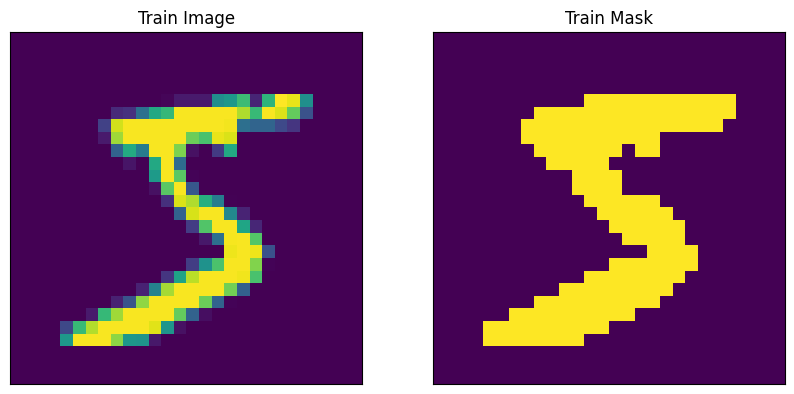

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the first image
axs[0].imshow(train_images[0])
axs[0].set_title('Train Image')

# Plot the second image
axs[1].imshow(train_masks[0])
axs[1].set_title('Train Mask')

# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


1/1 [==============================] - 0s 217ms/step


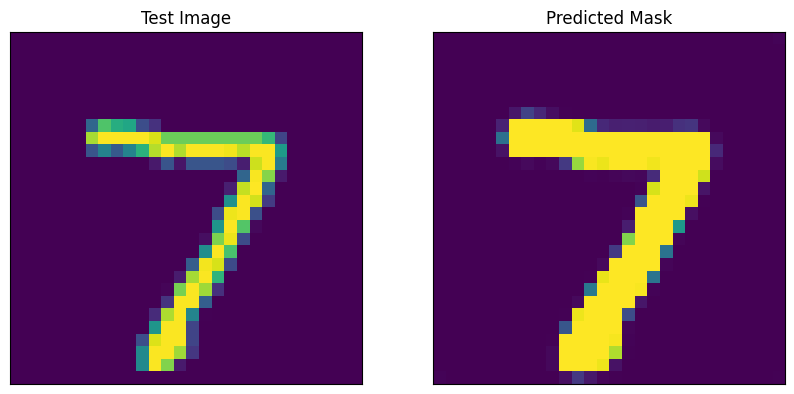

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the first image
axs[0].imshow(test_images[0])
axs[0].set_title('Test Image')

# Plot the second image
axs[1].imshow(unet.predict(test_images[0].reshape((1,28,28,1))).reshape((28,28,1)))
axs[1].set_title('Predicted Mask')

# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


#FAKE MULTICLASS UNET

In [ ]:
def mask_to_rgb(mask):
    color_map = np.array([
        [0, 0, 255],    # Blue for digit 0
        [0, 255, 0],    # Green for digit 1
        [255, 0, 0],    # Red for digit 2
        [0, 255, 255],  # Cyan for digit 3
        [255, 0, 255],  # Magenta for digit 4
        [255, 255, 0],  # Yellow for digit 5
        [128, 0, 0],    # Maroon for digit 6
        [0, 128, 0],    # Dark Green for digit 7
        [0, 0, 128],    # Navy for digit 8
        [128, 128, 128],# Grey for digit 9
        [255, 255, 255],# White for background
        [0, 0, 0]       # Black for intersection
    ]) / 255
    return (mask @ color_map).clip(0, 1)


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy as np

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the images to [0, 1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape the images to (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Create a new dataset for multi-digit images
x_train_multi = np.zeros((x_train.shape[0]//2, 28, 28, 1))
x_test_multi = np.zeros((x_test.shape[0]//2, 28, 28, 1))

# Overlay images of digits on top of each other
for i in range(x_train.shape[0]//2):
    x_train_multi[i] = np.maximum(x_train[2*i], x_train[2*i+1])

for i in range(x_test.shape[0]//2):
    x_test_multi[i] = np.maximum(x_test[2*i], x_test[2*i+1])

# Create a new target dataset for multi-digit masks
y_train_multi = np.zeros((y_train.shape[0]//2, 28, 28, 12))
y_test_multi = np.zeros((y_test.shape[0]//2, 28, 28, 12))

# Create masks for each digit and background
for i in range(y_train.shape[0]//2):
    y_train_multi[i, ..., y_train[2*i]] = np.where(x_train[2*i] > 0, 1, 0).squeeze()
    y_train_multi[i, ..., y_train[2*i+1]] = np.where(x_train[2*i+1] > 0, 1, 0).squeeze()
    y_train_multi[i, ..., 10] = np.where(x_train_multi[i] == 0, 1, 0).squeeze() # background mask

for i in range(y_test.shape[0]//2):
    y_test_multi[i, ..., y_test[2*i]] = np.where(x_test[2*i] > 0, 1, 0).squeeze()
    y_test_multi[i, ..., y_test[2*i+1]] = np.where(x_test[2*i+1] > 0, 1, 0).squeeze()
    y_test_multi[i, ..., 10] = np.where(x_test_multi[i] == 0, 1, 0).squeeze() # background mask

# Create interception mask class
intersection_mask_train = (y_train_multi[..., :10].sum(axis=-1) > 1).astype(int)
intersection_mask_test = (y_test_multi[..., :10].sum(axis=-1) > 1).astype(int)

# Where there's intersection, set all digit classes to 0
y_train_multi[..., :10] = y_train_multi[..., :10] * (1 - np.expand_dims(intersection_mask_train, axis=-1))
y_test_multi[..., :10] = y_test_multi[..., :10] * (1 - np.expand_dims(intersection_mask_test, axis=-1))

# Set the intersection class
y_train_multi[..., 11] = intersection_mask_train
y_test_multi[..., 11] = intersection_mask_test

# Create a new target dataset for digit vs background masks
y_train_binary = np.zeros((y_train.shape[0]//4, 28, 28, 12))
y_test_binary = np.zeros((y_test.shape[0]//4, 28, 28, 12))

# Create binary masks for digits and background
for i in range(y_train.shape[0]//4):
    y_train_binary[i, ..., y_train[i]] = np.where(x_train[i] > 0, 1, 0).squeeze()  # digit mask
    y_train_binary[i, ..., 10] = np.where(x_train[i] == 0, 1, 0).squeeze()  # background mask

for i in range(y_test.shape[0]//4):
    y_test_binary[i, ..., y_test[i]] = np.where(x_test[i] > 0, 1, 0).squeeze()  # digit mask
    y_test_binary[i, ..., 10] = np.where(x_test[i] == 0, 1, 0).squeeze()  # background mask


# Now combine the binary and multi-digit masks
y_train_combined = np.concatenate([y_train_binary, y_train_multi], axis=0)
y_test_combined = np.concatenate([y_test_binary, y_test_multi], axis=0)

# Create datasets for binary digit images
x_train_binary = x_train[:x_train.shape[0]//4]
x_test_binary = x_test[:x_test.shape[0]//4]

# Do the same for the images
x_train_combined = np.concatenate([x_train_binary, x_train_multi], axis=0)
x_test_combined = np.concatenate([x_test_binary, x_test_multi], axis=0)



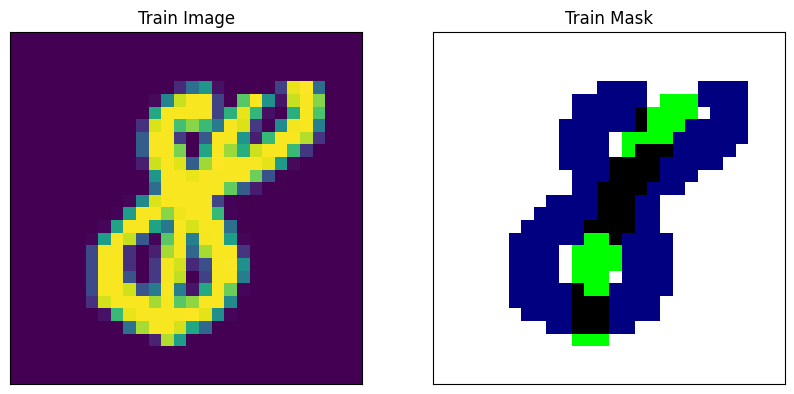

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

picture = 43000

# Plot the first image
axs[0].imshow(x_train_combined[picture])
axs[0].set_title('Train Image')

# Plot the second image
axs[1].imshow(mask_to_rgb(y_train_combined[picture]))
axs[1].set_title('Train Mask')

# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


class UNet:
    def __init__(self, input_shape=(28, 28, 1), num_classes=12):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def encoder(self, inputs):
        conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Dropout(0.1)(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Dropout(0.1)(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        return conv1, conv2, pool2

    def decoder(self, conv1, conv2, encoded):
        up1 = UpSampling2D(size=(2, 2))(encoded)
        merge1 = Concatenate(axis=3)([conv2, up1])
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
        conv3 = BatchNormalization()(conv3)
        conv3 = Dropout(0.1)(conv3)

        up2 = UpSampling2D(size=(2, 2))(conv3)
        merge2 = Concatenate(axis=3)([conv1, up2])
        conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)
        conv4 = BatchNormalization()(conv4)
        conv4 = Dropout(0.1)(conv4)

        return conv4

    def build_model(self):
        inputs = Input(self.input_shape)
        conv1, conv2, encoded = self.encoder(inputs)
        decoded = self.decoder(conv1, conv2, encoded)
        outputs = Conv2D(self.num_classes, (1, 1), activation='softmax')(decoded)
        return Model(inputs=inputs, outputs=outputs)

    def compile(self, optimizer='adam'):
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, x, y, epochs=1, batch_size=32, validation_split=0.1):
        self.model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
        lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[lr_reducer])

    def predict(self, x):
        return self.model.predict(x)


In [ ]:
# Initialize U-Net model
unet = UNet(input_shape=(28, 28, 1), num_classes=12)

# Compile the model
unet.compile(optimizer='adam')

# Train the model
unet.train(x_train_combined, y_train_combined, epochs=60, batch_size=256)


Epoch 1/60
159/159 [==============================] - 20s 96ms/step - loss: 1.0976 - accuracy: 0.7275 - val_loss: 0.9125 - val_accuracy: 0.7745 - lr: 1.0000e-04
Epoch 2/60
159/159 [==============================] - 14s 88ms/step - loss: 0.6862 - accuracy: 0.8035 - val_loss: 0.8211 - val_accuracy: 0.7393 - lr: 1.0000e-04
Epoch 3/60
159/159 [==============================] - 14s 89ms/step - loss: 0.5738 - accuracy: 0.8227 - val_loss: 0.7226 - val_accuracy: 0.7510 - lr: 1.0000e-04
Epoch 4/60
159/159 [==============================] - 14s 88ms/step - loss: 0.5082 - accuracy: 0.8379 - val_loss: 0.5253 - val_accuracy: 0.8271 - lr: 1.0000e-04
Epoch 5/60
159/159 [==============================] - 14s 88ms/step - loss: 0.4624 - accuracy: 0.8498 - val_loss: 0.4567 - val_accuracy: 0.8458 - lr: 1.0000e-04
Epoch 6/60
159/159 [==============================] - 14s 87ms/step - loss: 0.4296 - accuracy: 0.8587 - val_loss: 0.4318 - val_accuracy: 0.8513 - lr: 1.0000e-04
Epoch 7/60
159/159 [==============

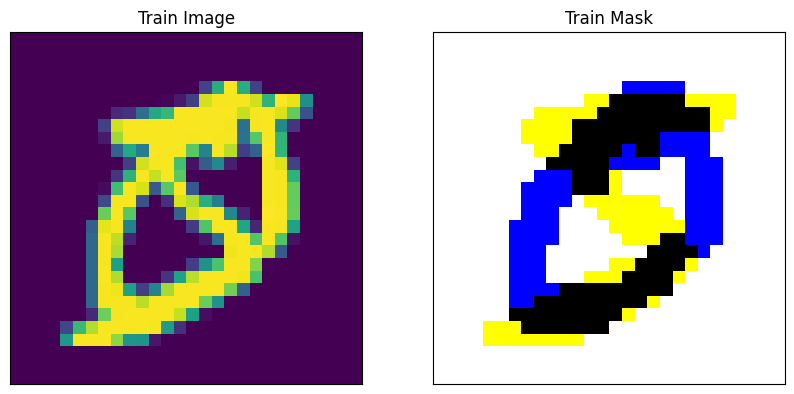

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the first image
axs[0].imshow(x_train_multi[0])
axs[0].set_title('Train Image')

# Plot the second image
axs[1].imshow(mask_to_rgb(y_train_multi[0]))
axs[1].set_title('Train Mask')

# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
x_test_combined.shape

(7500, 28, 28, 1)

1/1 [==============================] - 0s 214ms/step


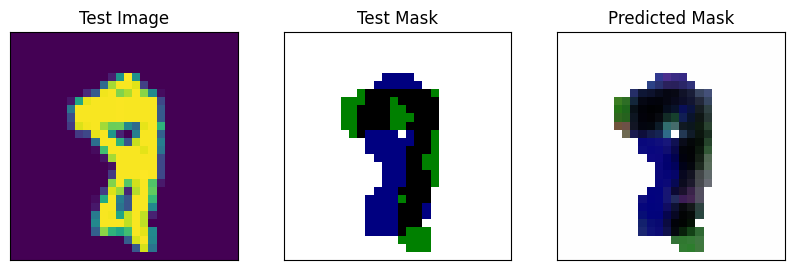

In [ ]:
import matplotlib.pyplot as plt

test_picture = 3003

fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

# Plot the first image
axs[0].imshow(x_test_combined[test_picture])
axs[0].set_title('Test Image')

# Plot the second image
axs[1].imshow(mask_to_rgb(y_test_combined[test_picture]))
axs[1].set_title('Test Mask')

# Plot the second image
axs[2].imshow(mask_to_rgb(unet.predict(x_test_combined[test_picture].reshape((1,28,28,1)))).reshape((28,28,3)))
axs[2].set_title('Predicted Mask')

# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

1/1 [==============================] - 0s 20ms/step


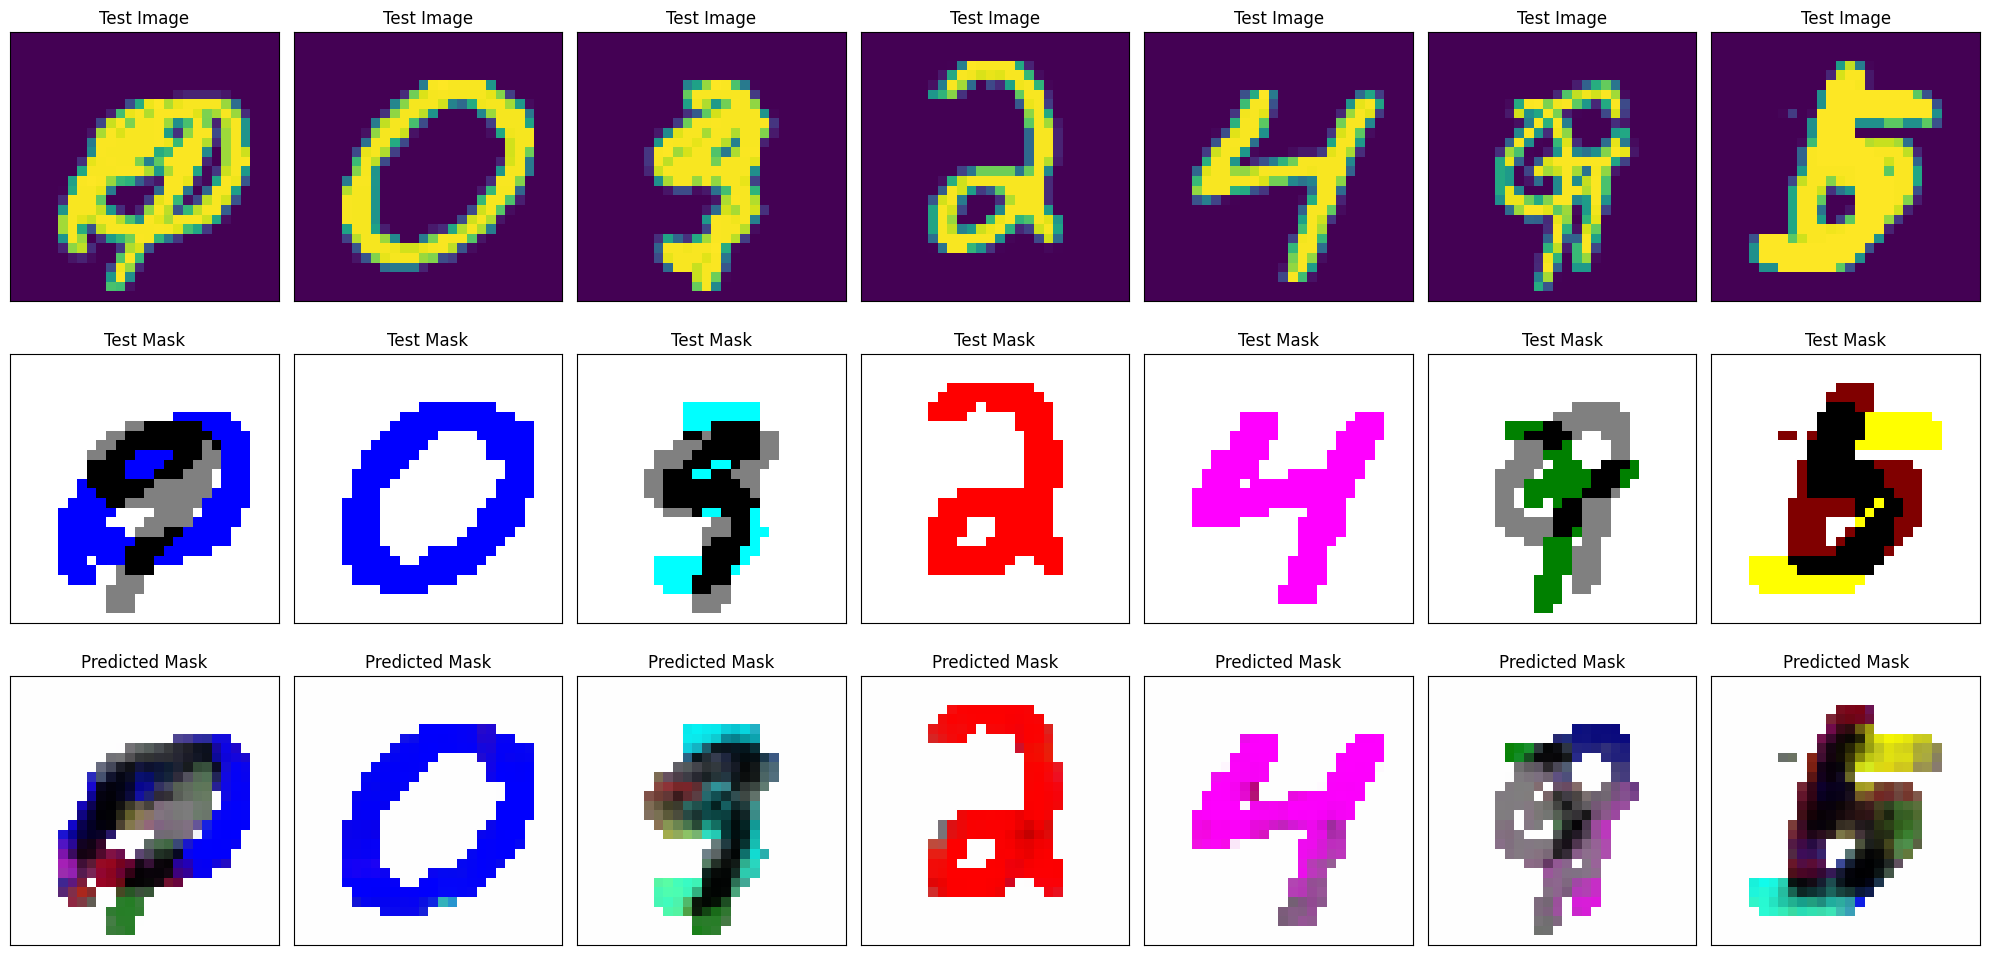

In [ ]:
fig, axs = plt.subplots(3, 7, figsize=(20, 10))  # 3 rows, 7 columns

test_pictures = np.random.choice(x_test_combined.shape[0], 7, replace=False)

for i, test_picture in enumerate(test_pictures):
    # Plot the test image
    axs[0, i].imshow(x_test_combined[test_picture])
    axs[0, i].set_title('Test Image')

    # Plot the test mask
    axs[1, i].imshow(mask_to_rgb(y_test_combined[test_picture]))
    axs[1, i].set_title('Test Mask')

    # Plot the predicted mask
    prediction = unet.predict(x_test_combined[test_picture].reshape((1,28,28,1)))
    axs[2, i].imshow(mask_to_rgb(prediction).reshape((28,28,3)))
    axs[2, i].set_title('Predicted Mask')

# Remove the x and y ticks
for i in range(3):
    for j in range(7):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.tight_layout()
plt.show()


#BIGGER UNET

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout

class UNet:
    def __init__(self, input_shape=(256, 256, 1)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def encoder(self, inputs):
        # First conv block
        conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = Dropout(0.1)(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        # Second conv block
        conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = Dropout(0.1)(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        # Third conv block
        conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = Dropout(0.2)(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        # Fourth conv block
        conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = Dropout(0.2)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        return conv1, conv2, conv3, conv4, pool4

    def decoder(self, conv1, conv2, conv3, conv4, encoded):
        # First upscaling block
        up1 = UpSampling2D(size=(2, 2))(encoded)
        merge1 = Concatenate(axis=3)([conv4, up1])
        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge1)

        # Second upscaling block
        up2 = UpSampling2D(size=(2, 2))(conv5)
        merge2 = Concatenate(axis=3)([conv3, up2])
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge2)

        # Third upscaling block
        up3 = UpSampling2D(size=(2, 2))(conv6)
        merge3 = Concatenate(axis=3)([conv2, up3])
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge3)

        # Fourth upscaling block
        up4 = UpSampling2D(size=(2, 2))(conv7)
        merge4 = Concatenate(axis=3)([conv1, up4])
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)

        return conv8

    def build_model(self):
        inputs = Input(self.input_shape)
        conv1, conv2, conv3, conv4, encoded = self.encoder(inputs)
       
        decoded = self.decoder(conv1, conv2, conv3, conv4, encoded)

        # Final Convolution layer to output the segmentation map. 
        # It has only one filter because the output is a binary mask.
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoded)

        return Model(inputs=inputs, outputs=outputs)

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        # The compile function is used to configure the learning process. 
        # The optimizer is the search technique used to update the weights in your model. 
        # Adam is a common choice. The loss function is used to measure the model's performance. 
        # Binary cross entropy is a common choice for binary classification problems, 
        # like ours, where each pixel is classified as either part of the object or part of the background.
        self.model.compile(optimizer=optimizer, loss=loss)

    def train(self, x, y, epochs=10, batch_size=32, validation_split=0.1):
        # The train function is used to train the model for a fixed number of epochs (iterations on a dataset). 
        # x is the input images, y is the target masks. 
        # The batch size is the number of samples per gradient update. 
        # Validation split fraction of the data to use as validation data.
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    def predict(self, x):
        # The predict function generates output predictions for the input samples.
        return self.model.predict(x)
